# Library Imports and Setup

In [2]:
# Install the mxnet library required for certain functionalities in SageMaker
# Specify numpy version to fix np.bool deprecated error
!pip install mxnet numpy==1.23.5

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import boto3
from botocore.exceptions import ClientError

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
import mxnet as mx
import datetime
import json
import time
from tabulate import tabulate
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 156.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 131.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.11 requires mkl, which is not installed.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/29/25 00:40:36] INFO     Found credentials from IAM Role:                                   ]8;id=930905;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=702536;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[03/29/25 00:40:52] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=958904;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=191294;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

[03/29/25 00:40:55] INFO     generated new fontManager                                         ]8;id=925009;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=532929;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

# SageMaker Setup and Configuration

In [3]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/mall/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/29/25 00:41:17] INFO     Found credentials from IAM Role:                                   ]8;id=127114;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=425257;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/29/25 00:41:18] INFO     Found credentials from IAM Role:                                   ]8;id=671875;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=457595;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=698197;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=343199;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/29/25 00:41:19] INFO     Same images used for training and inference. Defaulting to image     ]8;id=582048;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=263424;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=874458;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=618679;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::174260070301:role/LabRole
AWS Region: us-east-1


# Load and Preprocess the Dataset

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

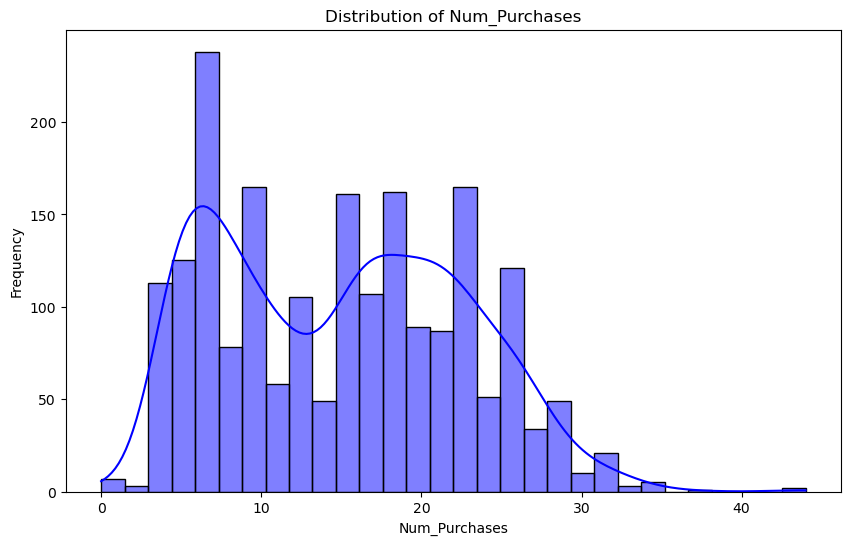

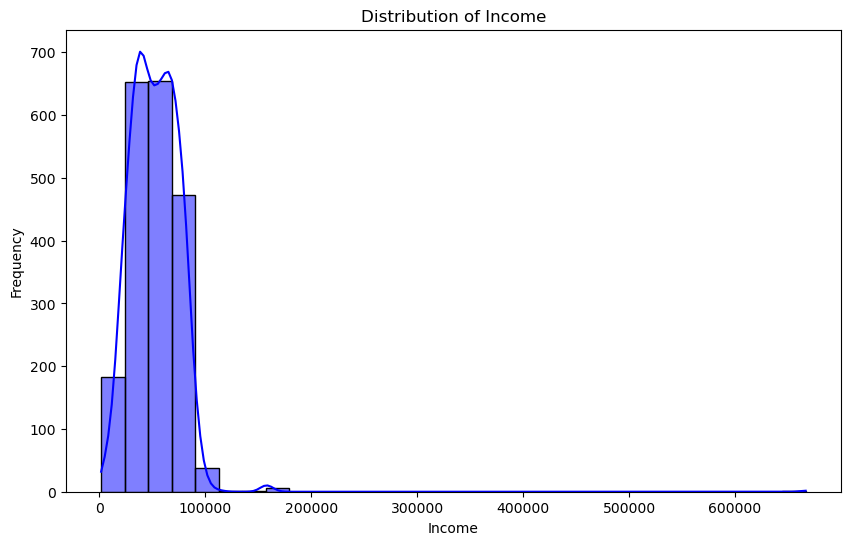

[666666. 162397. 160803. ...   3502.   2447.   1730.]
Data uploaded to S3: s3://sagemaker-us-east-1-174260070301/sagemaker/mall/kmeans-all/customer_engagement_data.csv
   Recency  Num_Purchases  Total_Spent   Income
0       58             25         1617  58138.0
1       38              6           27  46344.0
2       26             21          776  71613.0
3       26              8           53  26646.0
4       94             19          422  58293.0
Elements in first bin: 560
Elements in second bin: 445
Elements in third bin: 537
Elements in fourth bin: 458


In [5]:
# Step 1: Load the Dataset
# Load the mall customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df = pd.read_csv('marketing_campaign.csv', sep='\t')

print(df.head())
print(df.shape[0])

# Step 2: Encode Categorical Variables
# The columns 'Education' and 'Marital_Status' need to be encoded.
print(df['Education'].unique())
print(df['Marital_Status'].unique())

# There are a few inconsistencies with the values in these columns.
# '2n Cycle' is a common European term that is typically the equivalent of a Masters.
# To account for this, we will change all 2n Cycle to Master
df[df['Education'] == '2n Cycle'] = 'Master'

# We will use ordinal encoding for Education.
education_order = ['Basic', 'Graduation', 'Master', 'PhD']
df['Education'] = OrdinalEncoder(categories=[education_order]).fit_transform(df[['Education']])

# There are also some weird values in the Marital_Status column ('Absurd', 'YOLO').
# 'Alone' is also hard to determine where it belongs in the other values, so we will remove all of these.
# Then we will use numerical encoding. Normally I would use One Hot encoding for this, but we cannot give 6 columns to the clustering algorithm.
df = df.drop(df[df['Marital_Status'].isin(['YOLO', 'Absurd', 'Alone'])].index)
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first=True)

# Step 3: Select Relevant Features
# For clustering, we focus on the features 'Gender', 'Age', 'Annual Income (k$)', and 'Spending Score (1-100)'.
# These features are selected and retained in the DataFrame for further processing.

# Speaking of relevant features, ID is irrelevant because it is a unique value.
# Drop the 'ID' column
df = df.drop(columns=['ID'])

# For clustering, good features to focus on are demographics like gender, age, income etc.
# There is no gender column, and we can create an age column. 
df['Year_Birth'] = pd.to_numeric(df['Year_Birth'], errors='coerce')
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
df = df.drop(columns=['Year_Birth'])

# Another possible feature is total amount spent, which we can create by combining all the 'amount spent' features.
amounts = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spent'] = df[amounts].sum(axis=1)
df.drop(columns=amounts, inplace=True)

# Another possible feature is total number of purchases, which we can create my combining all the 'num purchases' features.
purchases = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Num_Purchases'] = df[purchases].sum(axis=1)
df.drop(columns=purchases, inplace=True)

# Since the focus of this business case is customer engagement and purchases,
# the most relevant features are Recency, Num_Purchases, Total_Spent, and Income.
df = df[['Recency', 'Num_Purchases', 'Total_Spent', 'Income']]

# Step 4: Convert Data for Machine Learning
# Convert the selected DataFrame into a NumPy array of type 'float32'.
# This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
# For some reason there is a string value in the 'Recency' column.
df.drop(df[df['Recency'] == 'Master'].index, inplace=True)

# Convert relevant columns to numeric, forcing errors to NaN
df[['Num_Purchases', 'Recency', 'Income', 'Total_Spent']] = df[['Num_Purchases', 'Recency', 'Income', 'Total_Spent']].apply(pd.to_numeric, errors='coerce')

# Drop rows where conversion resulted in NaN
df = df.dropna(subset=['Num_Purchases', 'Recency', 'Income', 'Total_Spent'])

# Plotting the distribution of 'Num_Purchases' using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['Num_Purchases'], kde=True, bins=30, color='blue')

# Adding labels and title
plt.title('Distribution of Num_Purchases')
plt.xlabel('Num_Purchases')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Plotting the distribution of 'Income' using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=True, bins=30, color='blue')

# Adding labels and title
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# The Income distribution looks very weird. Let's get rid of some of the outliers.
sorted_income = df['Income'].sort_values(ascending=False).values
print(sorted_income)
df = df[df['Income'] <= 110000]

data_np = df.values.astype('float32')

# # Step 5: Save and Upload Preprocessed Data
# # Save the preprocessed dataset to a CSV file, without the index.
# # This file is then uploaded to an S3 bucket, making it accessible for machine learning tasks in SageMaker.
df.to_csv('customer_engagement_data.csv', index=False)
data_uri = sagemaker_session.upload_data('customer_engagement_data.csv', key_prefix=prefix)

# # Output the S3 URI of the uploaded dataset for reference, confirming the successful upload.
print(f"Data uploaded to S3: {data_uri}")

# # Finally, display the first few rows of the processed dataset to verify the preprocessing steps.
print(df.head())

num_first_bin = (df['Num_Purchases'] <= 8).sum()
num_second_bin = ((df['Num_Purchases'] >= 9) & (df['Num_Purchases'] <= 15)).sum()
num_third_bin = ((df['Num_Purchases'] >= 16) & (df['Num_Purchases'] <= 21)).sum()
num_fourth_bin = (df['Num_Purchases'] >= 22).sum()

print(f"Elements in first bin: {num_first_bin}")
print(f"Elements in second bin: {num_second_bin}")
print(f"Elements in third bin: {num_third_bin}")
print(f"Elements in fourth bin: {num_fourth_bin}")

# These will be the sizes of the 4 bins.


# Create a 3D Scatter Plot

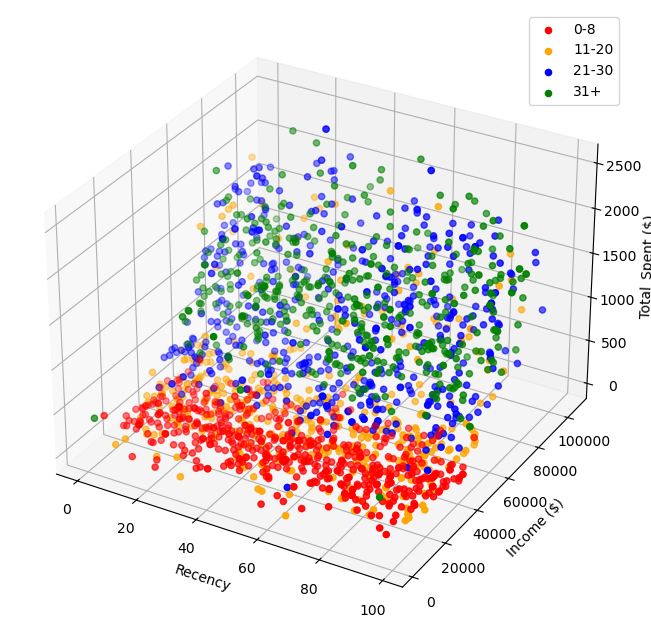

In [6]:
# Import the required libraries for data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Since there is no gender attribute, the colour of the points will refer to 
# ranges of Num_Purchases.

# Step 1: Create a 3D scatter plot
# Initialize a figure with a specific size for the 3D scatter plot.
fig = plt.figure(figsize=(10, 8))

# Add a 3D subplot to the figure
# '111' indicates 1x1 grid, first subplot. 'projection='3d'' is used to create a 3D projection.
ax = fig.add_subplot(111, projection='3d')

# Step 2: Plot data points, colored by Num_Purchases
# Plots their age, annual income, and spending score.
ax.scatter(df[df['Num_Purchases'] <= 8]['Recency'],
           df[df['Num_Purchases'] <= 8]['Income'],
           df[df['Num_Purchases'] <= 8]['Total_Spent'],
           c='red', label='0-8')

ax.scatter(df[(df['Num_Purchases'] >= 9) & (df['Num_Purchases'] <= 15)]['Recency'],
           df[(df['Num_Purchases'] >= 9) & (df['Num_Purchases'] <= 15)]['Income'],
           df[(df['Num_Purchases'] >= 9) & (df['Num_Purchases'] <= 15)]['Total_Spent'], 
           c='orange', label='11-20')

ax.scatter(df[(df['Num_Purchases'] >= 16) & (df['Num_Purchases'] <= 21)]['Recency'],
           df[(df['Num_Purchases'] >= 16) & (df['Num_Purchases'] <= 21)]['Income'],
           df[(df['Num_Purchases'] >= 16) & (df['Num_Purchases'] <= 21)]['Total_Spent'], 
           c='blue', label='21-30')

ax.scatter(df[df['Num_Purchases'] >= 22]['Recency'],
           df[df['Num_Purchases'] >= 22]['Income'],
           df[df['Num_Purchases'] >= 22]['Total_Spent'],
           c='green', label='31+')

# Step 3: Set labels and legend
# Adding axis labels and a legend to make the plot more informative.
ax.set_xlabel('Recency')
ax.set_ylabel('Income ($)')
ax.set_zlabel('Total_Spent ($)')
ax.legend()

# Display the plot
plt.show()

# KMeans Model Training

In [7]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(3, 9)

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/mall/kmeans-all/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-mall-all-k-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=4  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

[03/29/25 00:43:45] INFO     Same images used for training and inference. Defaulting to image     ]8;id=777060;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=110825;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=617492;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=815855;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=911981;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=467760;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=702655;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=351022;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-29-00-43-45-367        ]8;id=565257;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=115497;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/29/25 00:43:46] INFO     Same images used for training and inference. Defaulting to image     ]8;id=20155;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=922063;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=962984;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=344093;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=715618;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=113698;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=115143;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=87218;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-29-00-43-46-553        ]8;id=409547;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=137521;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/29/25 00:43:48] INFO     Same images used for training and inference. Defaulting to image     ]8;id=916050;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=967609;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=698717;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=859626;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=25072;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=828060;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=217665;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=801890;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-29-00-43-48-461        ]8;id=249341;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=683083;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/29/25 00:43:49] INFO     Same images used for training and inference. Defaulting to image     ]8;id=690408;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=260667;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=117888;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=69480;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=869849;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=162183;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=64917;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=894781;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-29-00-43-49-759        ]8;id=350838;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=861968;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/29/25 00:43:51] INFO     Same images used for training and inference. Defaulting to image     ]8;id=363116;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=437485;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=772212;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=951536;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=751568;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=200277;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=738515;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=575073;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-29-00-43-51-129        ]8;id=703105;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=398691;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/29/25 00:43:52] INFO     Same images used for training and inference. Defaulting to image     ]8;id=84427;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=505084;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=418568;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=617936;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=694138;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=723767;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=569418;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=317577;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-29-00-43-52-959        ]8;id=350016;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=6392;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

  k Value  S3 Model Artifact Path
---------  -------------------------------------------------------------------------------------------------------------------------
        3  s3://sagemaker-us-east-1-174260070301/sagemaker/mall/kmeans-all/output/kmeans-2025-03-29-00-43-45-367/output/model.tar.gz
        4  s3://sagemaker-us-east-1-174260070301/sagemaker/mall/kmeans-all/output/kmeans-2025-03-29-00-43-46-553/output/model.tar.gz
        5  s3://sagemaker-us-east-1-174260070301/sagemaker/mall/kmeans-all/output/kmeans-2025-03-29-00-43-48-461/output/model.tar.gz
        6  s3://sagemaker-us-east-1-174260070301/sagemaker/mall/kmeans-all/output/kmeans-2025-03-29-00-43-49-759/output/model.tar.gz
        7  s3://sagemaker-us-east-1-174260070301/sagemaker/mall/kmeans-all/output/kmeans-2025-03-29-00-43-51-129/output/model.tar.gz
        8  s3://sagemaker-us-east-1-174260070301/sagemaker/mall/kmeans-all/output/kmeans-2025-03-29-00-43-52-959/output/model.tar.gz


# Determine K through Elbow Plot

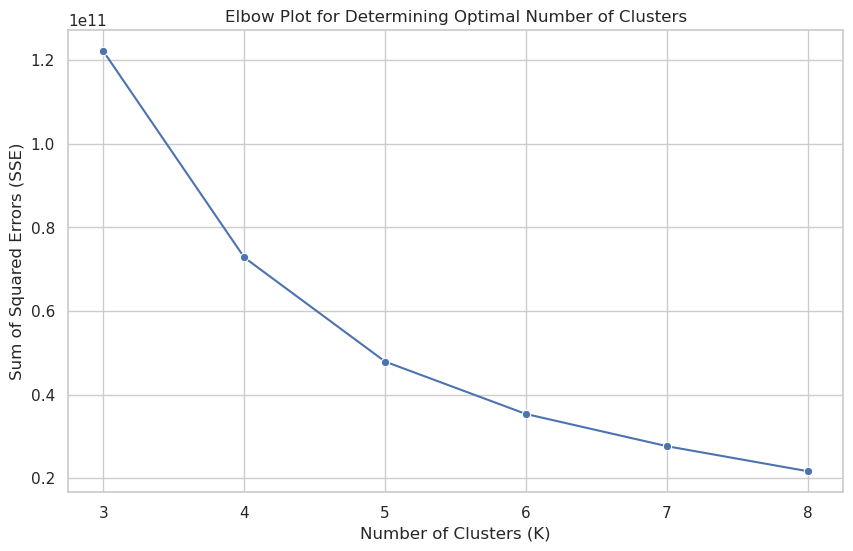

In [8]:
# List to store the Sum of Squared Errors (SSE) for each value of K
sse_values = []

# Iterate over each trained model's path to calculate SSE
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate SSE for this value of K
        sse = np.sum((data_np - centroids[closest_centroids])**2)
        sse_values.append(sse)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Create and display the Elbow Plot using seaborn and matplotlib
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks([k for k, _ in model_paths])
plt.show()

# Determine K through using Silhouette Method

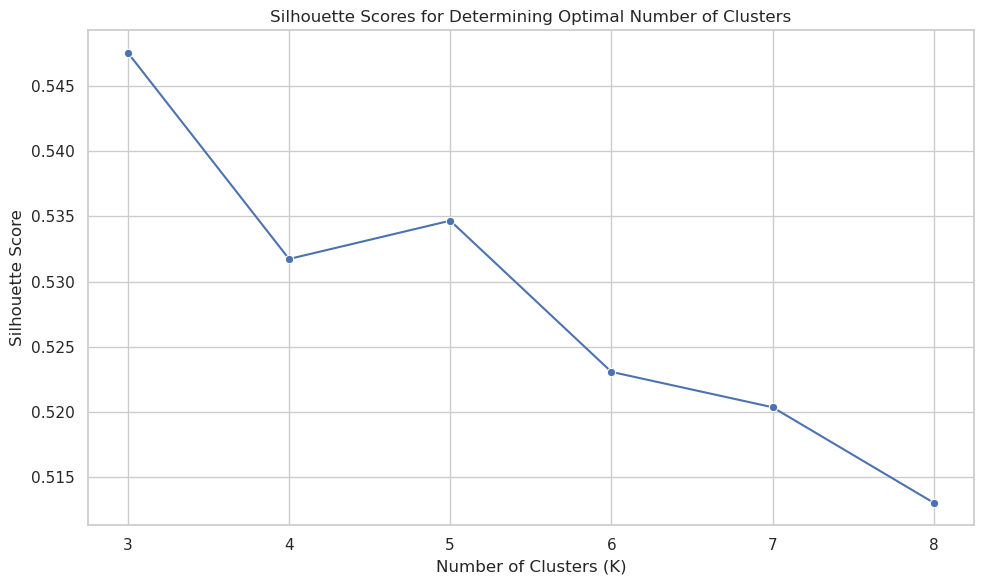

In [9]:
# List to store the silhouette scores for each value of K
silhouette_scores = []

# Iterate over each trained model's path to calculate its silhouette score
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate the silhouette score for this value of K
        silhouette_score_value = silhouette_score(data_np, closest_centroids)
        silhouette_scores.append(silhouette_score_value)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores for different values of K, if available
if silhouette_scores:  # Ensure the list is not empty
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()
else:
    print("No silhouette scores to plot.")


# Visualize the centroids for the optimal K value and display the cluster assignments for each datapoint

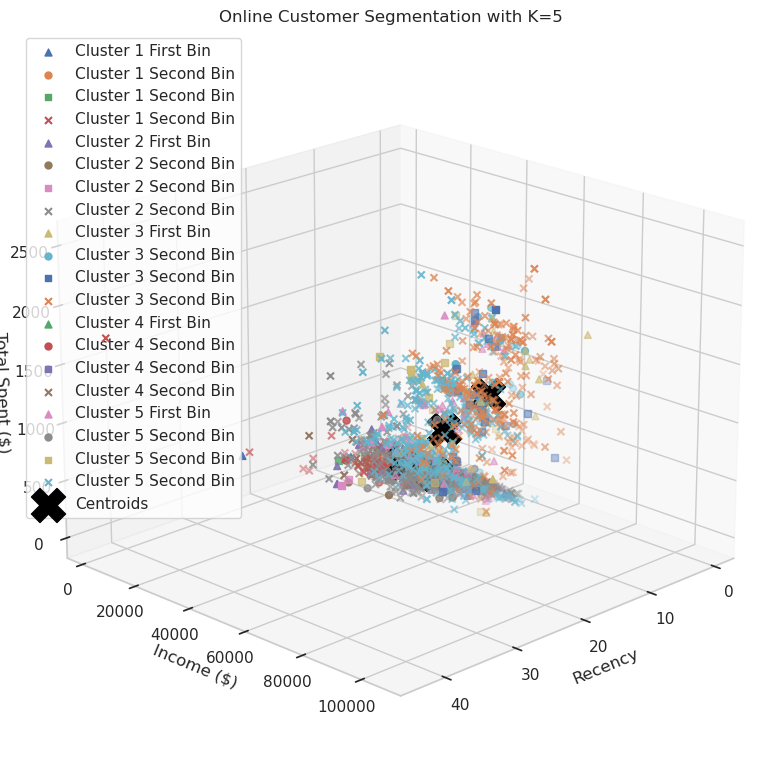

[[4.9333336e+01 7.3548384e+00 7.4100342e+01 2.0388105e+04]
 [4.9421173e+01 1.6177927e+01 4.5175452e+02 5.1986410e+04]
 [5.0031609e+01 2.0833334e+01 1.4634941e+03 8.1918477e+04]
 [4.7766918e+01 9.1109018e+00 1.3786279e+02 3.6446992e+04]
 [4.8872486e+01 2.0700224e+01 1.0353267e+03 6.6670078e+04]]


In [10]:
## Specify the optimal number of clusters determined previously
best_k = 5

# Retrieve the model path for the best K value from the list of trained models
best_model_path = next(path for k, path in model_paths if k == best_k)

# Download the best model artifacts from S3
local_path = f'/tmp/model-k-{best_k}.tar.gz'
s3_client.download_file(bucket, best_model_path.replace(f's3://{bucket}/', ''), local_path)

# Extract the model artifacts
with tarfile.open(local_path) as tar:
    tar.extractall(path=f'/tmp/k-{best_k}')

# Load the KMeans model parameters from the extracted files
kmeans_model_params = mx.ndarray.load(f'/tmp/k-{best_k}/model_algo-1')
centroids = kmeans_model_params[0].asnumpy()

# Calculate distances from each point to the centroids and determine closest centroid for each point
distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
closest_centroids = np.argmin(distances, axis=0)

# Initialize a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points, color-coded by cluster assignment and number of purchases
for i in range(best_k):
    cluster_points = data_np[closest_centroids == i]
    first_bin = cluster_points[cluster_points[:, 0] <= 8] # filter first bin
    second_bin = cluster_points[(cluster_points[:,0] >= 9) & (cluster_points[:, 0] <= 15)] # filter second bin
    third_bin = cluster_points[(cluster_points[:,0] >= 16) & (cluster_points[:, 0] <= 21)] # filter third bin
    fourth_bin = cluster_points[cluster_points[:, 0] >= 22] # filter fourth bin
    
    ax.scatter(first_bin[:, 1], first_bin[:, 3], first_bin[:, 2], s=25, label=f'Cluster {i+1} First Bin', marker='^')
    ax.scatter(second_bin[:, 1], second_bin[:, 3], second_bin[:, 2], s=25, label=f'Cluster {i+1} Second Bin', marker='o')
    ax.scatter(third_bin[:, 1], third_bin[:, 3], third_bin[:, 2], s=25, label=f'Cluster {i+1} Second Bin', marker='s')
    ax.scatter(fourth_bin[:, 1], fourth_bin[:, 3], fourth_bin[:, 2], s=25, label=f'Cluster {i+1} Second Bin', marker='x')

# Plot centroids
ax.scatter(centroids[:, 1], centroids[:, 3], centroids[:, 2], s=600, c='black', marker='X', label='Centroids', zorder=5, depthshade=False)

# Customize the view angle for better visualization
ax.view_init(elev=20, azim=45)

# Set titles and labels
ax.set_title(f'Online Customer Segmentation with K={best_k}')
ax.set_xlabel('Recency')
ax.set_ylabel('Income ($)')
ax.set_zlabel('Total Spent ($)')
ax.legend()

plt.tight_layout()
plt.show()

print(centroids)


# Model Deployment to SageMaker Endpoint

In [11]:
# Specify names for the endpoint and its configuration
endpoint_name = 'datawhisperer-kmeans'
endpoint_config_name = 'datawhisperer-kmeans'

# Function to wait for endpoint configuration deletion
def wait_for_endpoint_config_deletion(endpoint_config_name):
    print(f'Waiting for endpoint configuration "{endpoint_config_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint configuration if it exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    wait_for_endpoint_config_deletion(endpoint_config_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

# Function to wait for endpoint deletion
def wait_for_endpoint_deletion(endpoint_name):
    print(f'Waiting for endpoint "{endpoint_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint if it exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    wait_for_endpoint_deletion(endpoint_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')

# Identify the best model based on prior analysis
best_k = 6  # Assuming best_k is determined through prior analysis
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model's artifacts
best_model = Model(
    model_data=best_model_s3_uri,
    image_uri=image_uri,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model to an endpoint
# Note: This operation can take several minutes to complete.
predictor = best_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

print(f'Model deployed to endpoint: {endpoint_name}')

Endpoint configuration "datawhisperer-kmeans" already exists. Deleting...
Waiting for endpoint configuration "datawhisperer-kmeans" to be deleted...
Endpoint configuration "datawhisperer-kmeans" deleted.
Endpoint "datawhisperer-kmeans" already exists. Deleting...
Waiting for endpoint "datawhisperer-kmeans" to be deleted...
Endpoint "datawhisperer-kmeans" deleted.


[03/29/25 00:49:14] INFO     Creating model with name: kmeans-2025-03-29-00-49-14-855               ]8;id=548732;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=599733;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/29/25 00:49:15] INFO     Creating endpoint-config with name datawhisperer-kmeans                ]8;id=363041;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=468987;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name datawhisperer-kmeans                       ]8;id=529212;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=134454;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-------!Model deployed to endpoint: datawhisperer-kmeans


# Cluster Associations and Centroids

In [65]:
# Initialize a Predictor object for the deployed SageMaker endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

def get_user_input(prompt):
    """Function to get user input; allows quitting by typing 'quit'."""
    user_input = input(prompt).strip()
    if user_input.lower() == 'quit':
        return None
    return user_input

def validate_and_prompt(feature_name, feature_prompt):
    """Validate and repeatedly prompt until a valid input or 'quit' is entered."""
    while True:
        user_input = get_user_input(feature_prompt)
        if user_input is None:  # User chose to exit
            return None
        try:
            # For gender, ensure it's 0 or 1; for other features, ensure they're positive numbers
            if feature_name == 'Gender':
                if user_input in ['0', '1']:
                    return user_input
                else:
                    print("Invalid input. Please enter 0 for Female or 1 for Male.")
            else:
                value = float(user_input)
                if value > 0:
                    return str(value)
                else:
                    print(f"Please enter a positive number for {feature_name}.")
        except ValueError:
            print(f"Invalid input. Please enter a number for {feature_name}.")

print("Cluster Prediction Program")
print("Enter the following information for a prediction, or type 'quit' to exit.")

while True:
    # Collect inputs from the user
    num_purchases = validate_and_prompt('Number of Purchases', "Enter number of purchases: ")
    if num_purchases is None: break
    recency = validate_and_prompt('Recency', "Enter number of days since customer's last purchase: ")
    if recency is None: break
    income = validate_and_prompt('Income', "Enter customer's yearly household income ($): ")
    if income is None: break
    total_spent = validate_and_prompt('Total Amount Spent', "Enter customer's total amount spent ($): ")
    if total_spent is None: break

    # Prepare the data for prediction
    data = f'{recency},{num_purchases},{total_spent},{income}\n'

    # Make prediction
    try:
        response = predictor.predict(data)
        # Parse the prediction response
        response_json = json.loads(response)
        cluster = response_json['predictions'][0]['closest_cluster']
        distance = response_json['predictions'][0]['distance_to_cluster']
        # Print the cluster assignment
        print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")
    except Exception as e:
        print(f"An error occurred during prediction: {str(e)}")

print("Program exited.")

Cluster Prediction Program
Enter the following information for a prediction, or type 'quit' to exit.


Enter number of purchases:  20
Enter number of days since customer's last purchase:  15
Enter customer's yearly household income ($):  90000
Enter customer's total amount spent ($):  700


The data point belongs to Cluster 3 with a distance of 91507.73 to the cluster center.


Enter number of purchases:  20
Enter number of days since customer's last purchase:  10
Enter customer's yearly household income ($):  20000
Enter customer's total amount spent ($):  1000


The data point belongs to Cluster 3 with a distance of 25983.04 to the cluster center.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:38                                                                                   │
│                                                                                                  │
│   35                                                                                             │
│   36 while True:                                                                                 │
│   37 │   # Collect inputs from the user                                                          │
│ ❱ 38 │   num_purchases = validate_and_prompt('Number of Purchases', "Enter number of purchase    │
│   39 │   if num_purchases is None: break                                                         │
│   40 │   recency = validate_and_prompt('Recency', "Enter number of days since customer's last    │
│   41 │   if recency is None: break                                                               │
│                                                                                                  │
│ in validate_and_prompt:14                                                                        │
│                                                                                                  │
│   11 def validate_and_prompt(feature_name, feature_prompt):                                      │
│   12 │   """Validate and repeatedly prompt until a valid input or 'quit' is entered."""          │
│   13 │   while True:                                                                             │
│ ❱ 14 │   │   user_input = get_user_input(feature_prompt)                                         │
│   15 │   │   if user_input is None:  # User chose to exit                                        │
│   16 │   │   │   return None                                                                     │
│   17 │   │   try:                                                                                │
│                                                                                                  │
│ in get_user_input:6                                                                              │
│                                                                                                  │
│    3                                                                                             │
│    4 def get_user_input(prompt):                                                                 │
│    5 │   """Function to get user input; allows quitting by typing 'quit'."""                     │
│ ❱  6 │   user_input = input(prompt).strip()                                                      │
│    7 │   if user_input.lower() == 'quit':                                                        │
│    8 │   │   return None                                                                         │
│    9 │   return user_input                                                                       │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/ipykernel/kernelbase.py:1282  │
│ in raw_input                                                                                     │
│                                                                                                  │
│   1279 │   │   if not self._allow_stdin:                                                         │
│   1280 │   │   │   msg = "raw_input was called, but this frontend does not support input reques  │
│   1281 │   │   │   raise StdinNotImplementedError(msg)                                           │
│ ❱ 1282 │   │   return self._input_request(                                                       │
│   1283 │   │   │   str(prompt),                                                                  │
│   1284 │   │   │   self._parent_ident["shell"],            

# Delete the Endpoint and Endpoint Config

In [12]:
# Prompt for confirmation before proceeding with the deletion
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':

    # Function to delete endpoint configuration
    def delete_endpoint_config(endpoint_config_name):
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
            else:
                raise

    # Function to delete the endpoint
    def delete_endpoint(endpoint_name):
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" does not exist.')
            else:
                raise

    # Delete the endpoint configuration
    delete_endpoint_config(endpoint_config_name)

    # Delete the endpoint
    delete_endpoint(endpoint_name)

else:
    print("Deletion cancelled. The endpoint and its configuration were not deleted.")

Are you sure you want to delete the endpoint and endpoint configuration? (yes/no):  yes


Endpoint configuration "mall-kmeans-all" exists. Deleting...
Endpoint configuration "mall-kmeans-all" deleted successfully.
Endpoint "mall-kmeans-all" exists. Deleting...
Endpoint "mall-kmeans-all" deleted successfully.
